In [1]:
# This code works in Python 3.10.6
import numpy as np
import pandas as pd
import networkx as nx
import dgl
from torch_geometric.datasets.dblp import DBLP
import torch
from torch import optim
import torch_geometric.utils.convert
import torch_geometric.transforms as T
from collections import Counter
import itertools
import os
import glob
import warnings
warnings.filterwarnings('ignore')

In [2]:
import sys  
sys.path.insert(1, '../../../evaluation/')
sys.path.insert(1, '../../model/')
sys.path.insert(1, '../../postprocessing/')
sys.path.insert(1, '../../select_explanation/')

In [3]:
import plots
import utils
import dblp_model as GNN
import dblp_postprocessing as postprocessing
import dblp_select_explanation as select_explanation

In [4]:
FEATURE_SIZE = 50
RUNS = 10

Create Metagraph

In [5]:
dataset = DBLP(root='./dblp_data', transform=T.Constant(node_types='conference'))
data = dataset[0]
data['conference'].pop('num_nodes')
#Create metagraph
g = torch_geometric.utils.convert.to_dgl(data)
meta_g= g.metagraph()

Original DBLP dataset with all node features

In [6]:
dataset = DBLP(root='./dblp_data', transform=T.Constant(node_types='conference'))
data = dataset[0]
print(data)

HeteroData(
  author={
    x=[4057, 334],
    y=[4057],
    train_mask=[4057],
    val_mask=[4057],
    test_mask=[4057],
  },
  paper={ x=[14328, 4231] },
  term={ x=[7723, 50] },
  conference={
    num_nodes=20,
    x=[20, 1],
  },
  (author, to, paper)={ edge_index=[2, 19645] },
  (paper, to, author)={ edge_index=[2, 19645] },
  (paper, to, term)={ edge_index=[2, 85810] },
  (paper, to, conference)={ edge_index=[2, 14328] },
  (term, to, paper)={ edge_index=[2, 85810] },
  (conference, to, paper)={ edge_index=[2, 14328] }
)


In [7]:
author_data = data['author'].x
df_author = pd.DataFrame(author_data)

imp_feat_author = utils.selected_features_var(data['author'].x, threshold=0.948).iloc[:, : FEATURE_SIZE]
imp_feat_author.head()

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
paper = data['paper'].x.tolist()
df_paper = pd.DataFrame(paper)
            
imp_feat_paper = utils.selected_features_var(df_paper, threshold=0.9845).iloc[:, : FEATURE_SIZE]
imp_feat_paper.head()

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
data['author'].x = torch.tensor(imp_feat_author.values).to(dtype=torch.float32)
data['paper'].x = torch.tensor(imp_feat_paper.values).to(dtype=torch.float32)

DBLP dataset with selected node features used for GNN training

In [10]:
data

HeteroData(
  author={
    x=[4057, 50],
    y=[4057],
    train_mask=[4057],
    val_mask=[4057],
    test_mask=[4057],
  },
  paper={ x=[14328, 50] },
  term={ x=[7723, 50] },
  conference={
    num_nodes=20,
    x=[20, 1],
  },
  (author, to, paper)={ edge_index=[2, 19645] },
  (paper, to, author)={ edge_index=[2, 19645] },
  (paper, to, term)={ edge_index=[2, 85810] },
  (paper, to, conference)={ edge_index=[2, 14328] },
  (term, to, paper)={ edge_index=[2, 85810] },
  (conference, to, paper)={ edge_index=[2, 14328] }
)

In [11]:
#List of edges in metagraph of DBLP
list(meta_g.edges())

[('author', 'paper'),
 ('paper', 'author'),
 ('paper', 'conference'),
 ('paper', 'term'),
 ('conference', 'paper'),
 ('term', 'paper')]

In [12]:
#Reading from file the generated node features using diffusion
class_path = '../../../graph generator/diffusion models/sampled_features_diffusion/no_dependence/discrete_diffusion/dblp/variance/'
term_path = '../../../graph generator/diffusion models/sampled_features_diffusion/no_dependence/tabddpm/dblp/'
class0  = pd.DataFrame(torch.load(class_path + 'author0_50feat.pt').cpu().numpy())
class1  = pd.DataFrame(torch.load(class_path + 'author1_50feat.pt').cpu().numpy())
class2  = pd.DataFrame(torch.load(class_path + 'author2_50feat.pt').cpu().numpy())
class3  = pd.DataFrame(torch.load(class_path + 'author3_50feat.pt').cpu().numpy())
paper  = pd.DataFrame(torch.load(class_path + 'paper_50feat.pt').cpu().numpy())
term  = pd.DataFrame(np.load(term_path + 'term_tabddpm.npy',allow_pickle=True))

In [13]:
df_class0=class0.reset_index(drop=True)
df_class1=class1.reset_index(drop=True)
df_class2=class2.reset_index(drop=True)
df_class3=class3.reset_index(drop=True)

In [14]:
graphs_path = '../../../graph generator/diffusion models/sampled_graphs_diffusion/'
print('Original no of graphs:',len([name for name in glob.iglob(graphs_path + 'dblp_10to15/*.gexf')]))

Original no of graphs: 1416


In [15]:
avg_max_pred_list = []
max_pred_list = []
graph_dict_list = []
softmax_dict_list = []
nodefeature_dict_list = []
all_edges_list = []
class_graphid_list = []

In [16]:
for i in range(0,RUNS):     

    model = GNN.HeteroGNN(data.metadata(), hidden_channels=64, out_channels=4,
                  num_layers=2)
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    data, model = data.to(device), model.to(device)
    
    with torch.no_grad():  # Initialize lazy modules.
        out = model(data.x_dict, data.edge_index_dict)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=0.001)
    
    best_val_acc = 0
    start_patience = patience = 100
    for epoch in range(1, 500):
        loss = GNN.train(data,model,optimizer)
        train_acc, val_acc, test_acc = GNN.test(data,model)
        if epoch%200==0:
            print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train: {train_acc:.4f}, '
              f'Val: {val_acc:.4f}, Test: {test_acc:.4f}')
    
        if best_val_acc <= val_acc:
            patience = start_patience
            best_val_acc = val_acc
        else:
            patience -= 1
    
        if patience <= 0:
            print('Stopping training as validation accuracy did not improve '
                  f'for {start_patience} epochs')
            break

        
    all_edges = {}
    softmax_dict = {}
    nodefeature_dict = {}
    graph_dict = {}

    #Read from file the synthetic graphs generated using diffusion to evaluate the trained GNN on the graphs
    for filepath in glob.iglob(graphs_path + 'dblp_10to15/*.gexf'):
        
        graph = nx.read_gexf(filepath)
    
        filename = os.path.basename(filepath)
        graph_id= filename.split('.')[0]
    
        nodeId_list = []
        node_type_list = []
    
        for key, value in graph.nodes(data=True):
            nodeId_list.append(key)
            node_type_list.append(value['node_type'])
     
        df_graph = pd.DataFrame()
        df_graph["nodeId"] = nodeId_list
        df_graph["class"] = node_type_list
      
    
        nodes,edges,author_node_features,paper_node_features,term_node_features,conf_nodes = postprocessing.get_node_features(graph,
                                                df_class0,df_class1,df_class2,df_class3,paper,term)
        
        small_graph_data, removed_edges, graph_edges = postprocessing.create_dataset(nodes,edges,
                                  author_node_features,paper_node_features,
                                  term_node_features,conf_nodes,graph_id,df_graph)
        
        all_edges.update(graph_edges)
        
        if (small_graph_data['author'].x.nelement()!=0) and \
        (small_graph_data['paper','to','author']) and \
        (small_graph_data['author','to','paper']) and \
        (small_graph_data['paper','to','conference']) and \
        (small_graph_data['paper','to','term']):
            
            small_graph_data= small_graph_data.to(device)
            softmax = select_explanation.evaluate_gnn(small_graph_data,model)
            softmax_dict[graph_id] = softmax
            nodefeature_dict[graph_id]={'author':small_graph_data['author'].x,
                                             'paper':small_graph_data['paper'].x,
                                             'term':small_graph_data['term'].x}
            graph_dict[graph_id]=df_graph
    
    print("No. of graphs evaluated: ",len(softmax_dict))

    avg_max_pred, max_pred, class_graphid = select_explanation.get_max_pred(softmax_dict,i)
    
    avg_max_pred_list.append(avg_max_pred)
    max_pred_list.append(max_pred)
    graph_dict_list.append(graph_dict)
    softmax_dict_list.append(softmax_dict)
    nodefeature_dict_list.append(nodefeature_dict)
    all_edges_list.append(all_edges)
    class_graphid_list.append(class_graphid)


Stopping training as validation accuracy did not improve for 100 epochs
No. of graphs evaluated:  231
Run0 1.0 1.0 1.0 0.9999998807907104
Stopping training as validation accuracy did not improve for 100 epochs
No. of graphs evaluated:  231
Run1 1.0 1.0 0.9999997615814209 1.0
Epoch: 200, Loss: 0.0062, Train: 1.0000, Val: 0.7475, Test: 0.7574
Stopping training as validation accuracy did not improve for 100 epochs
No. of graphs evaluated:  231
Run2 1.0 1.0 0.9997547268867493 0.9999998807907104
Stopping training as validation accuracy did not improve for 100 epochs
No. of graphs evaluated:  231
Run3 1.0 1.0 0.9999998807907104 1.0
Epoch: 200, Loss: 0.0062, Train: 1.0000, Val: 0.7450, Test: 0.7565
Stopping training as validation accuracy did not improve for 100 epochs
No. of graphs evaluated:  231
Run4 1.0 1.0 1.0 1.0
Stopping training as validation accuracy did not improve for 100 epochs
No. of graphs evaluated:  231
Run5 1.0 1.0 1.0 1.0
Stopping training as validation accuracy did not impr

In [17]:
avg_max_pred_list

[0.9999999701976776,
 0.9999999403953552,
 0.9999386519193649,
 0.9999999701976776,
 1.0,
 1.0,
 1.0,
 1.0,
 0.9999997317790985,
 0.9999996721744537]

In [18]:
print('Mean',np.mean(avg_max_pred_list))

Mean 0.9999937936663628


In [19]:
print('Standard Deviation',np.std(avg_max_pred_list))

Standard Deviation 1.8380930244553415e-05


In [20]:
m = max(avg_max_pred_list)
index = avg_max_pred_list.index(m)
index

4

In [21]:
class0_graphid = class_graphid_list[index][0]
class1_graphid = class_graphid_list[index][1]
class2_graphid = class_graphid_list[index][2]
class3_graphid = class_graphid_list[index][3]

In [22]:
max_pred0 = max_pred_list[index][0]
max_pred1 = max_pred_list[index][1]
max_pred2 = max_pred_list[index][2]
max_pred3 = max_pred_list[index][3]

In [23]:
all_edges = all_edges_list[index]

In [24]:
graph_dict = graph_dict_list[index]

In [25]:
softmax_dict = softmax_dict_list[index]

In [26]:
nodefeature_dict = nodefeature_dict_list[index]

Plotting explanation graph and node features for each class of Author node

Node colors:

Paper - Blue

Author - Red

Term - Darkgreen

Conference - Orange

Number of nodes:  12
graph id:  graph589
Max pred probability for class 0 is 1.0


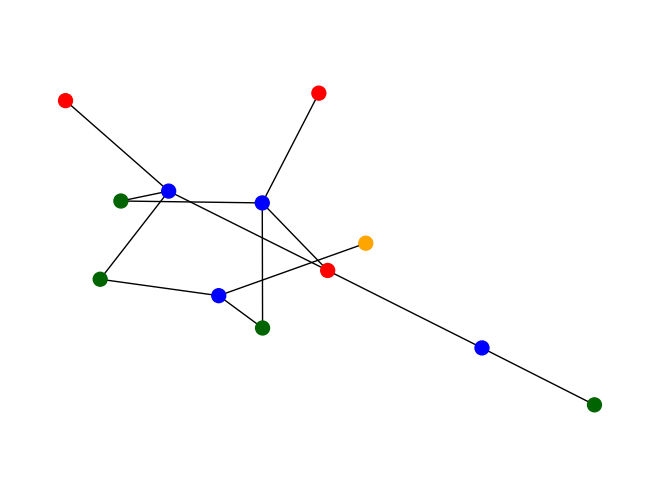

In [27]:
explanation_graph0 = plots.plot_graph(class0_graphid, max_pred0, 0, all_edges[class0_graphid],graph_dict[class0_graphid])

In [28]:
#all_edges

In [29]:
ind= utils.index_2d(softmax_dict[class0_graphid], max_pred0)[0]
list0= nodefeature_dict[class0_graphid]['author'].cpu().numpy()[ind]
Counter(list0)

Counter({1.0: 30, 0.0: 20})

In [30]:
print(list0)

[0. 1. 0. 1. 0. 0. 1. 1. 1. 1. 0. 1. 1. 1. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0.
 1. 0. 1. 1. 1. 1. 1. 0. 1. 1. 0. 0. 1. 1. 1. 1. 0. 0. 1. 1. 0. 1. 1. 0.
 1. 1.]


In [31]:
utils.index_2d(softmax_dict[class0_graphid], max_pred0)

(0, 1)

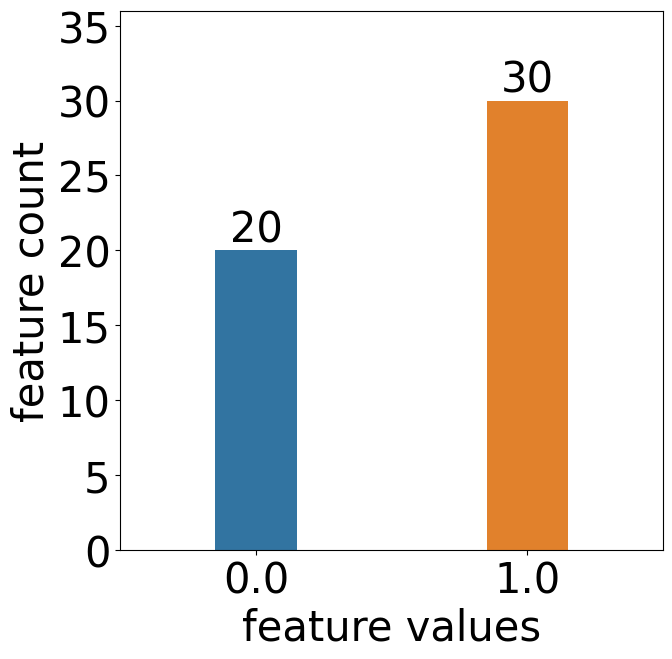

In [32]:
plots.count_plot(list0)

Number of nodes:  14
graph id:  graph990
Max pred probability for class 1 is 1.0


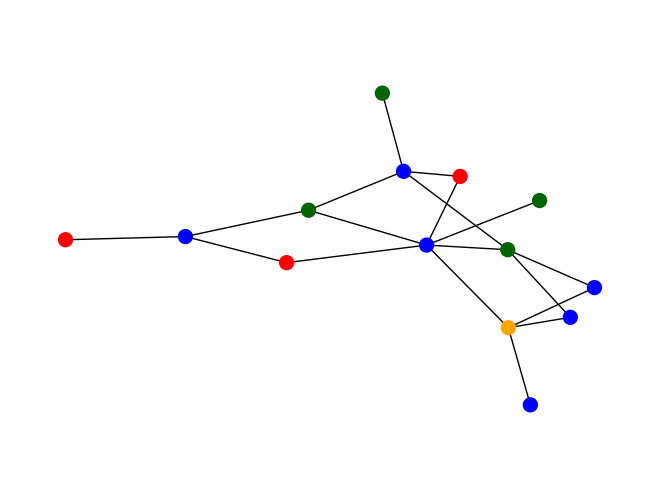

In [33]:
explanation_graph1 = plots.plot_graph(class1_graphid, max_pred1, 1, all_edges[class1_graphid],graph_dict[class1_graphid])

In [34]:
ind= utils.index_2d(softmax_dict[class1_graphid], max_pred1)[0]
list1= nodefeature_dict[class1_graphid]['author'].cpu().numpy()[ind]
Counter(list1)

Counter({1.0: 26, 0.0: 24})

In [35]:
print(list1)

[0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 1. 1. 1. 0. 1. 1. 0. 1. 0. 0. 1. 1. 0.
 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 0. 1. 0. 1. 1. 0. 1.
 0. 0.]


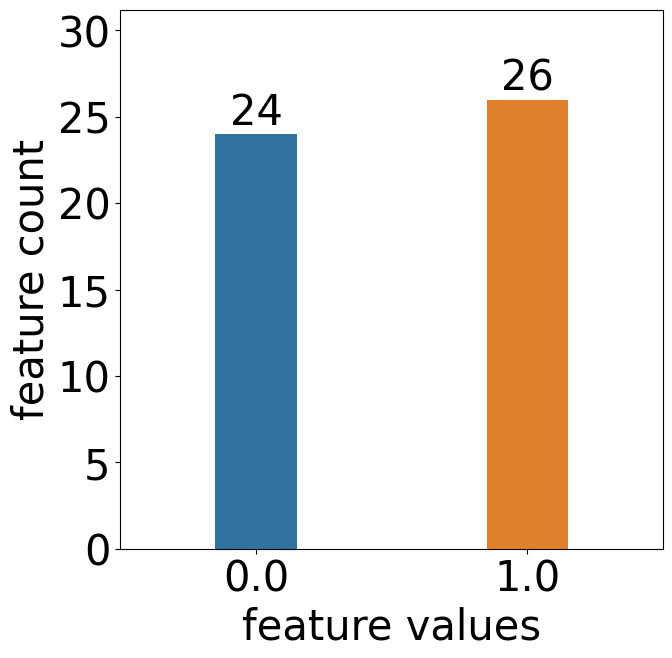

In [36]:
plots.count_plot(list1)

Number of nodes:  15
graph id:  graph1323
Max pred probability for class 2 is 1.0


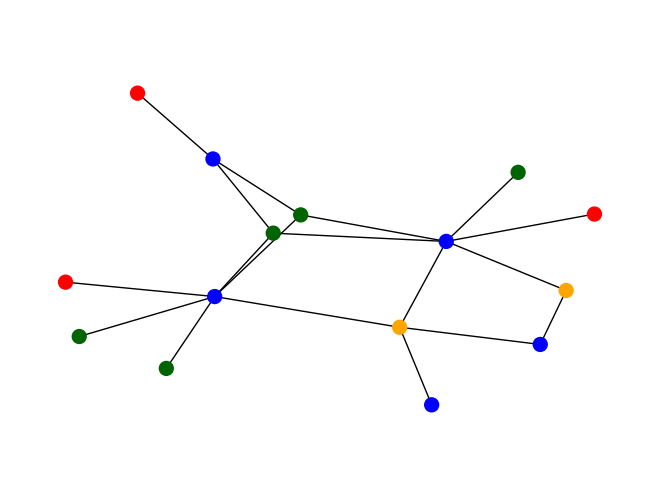

In [37]:
explanation_graph2 = plots.plot_graph(class2_graphid, max_pred2, 2, all_edges[class2_graphid],graph_dict[class2_graphid])

In [38]:
ind= utils.index_2d(softmax_dict[class2_graphid], max_pred2)[0]
list2= nodefeature_dict[class2_graphid]['author'].cpu().numpy()[ind]
Counter(list2)

Counter({1.0: 27, 0.0: 23})

In [39]:
print(list2)

[1. 1. 1. 0. 1. 0. 1. 0. 0. 0. 1. 1. 1. 0. 1. 0. 0. 1. 0. 0. 1. 1. 1. 1.
 0. 0. 0. 1. 1. 0. 0. 1. 1. 1. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 1. 1. 1. 0.
 1. 1.]


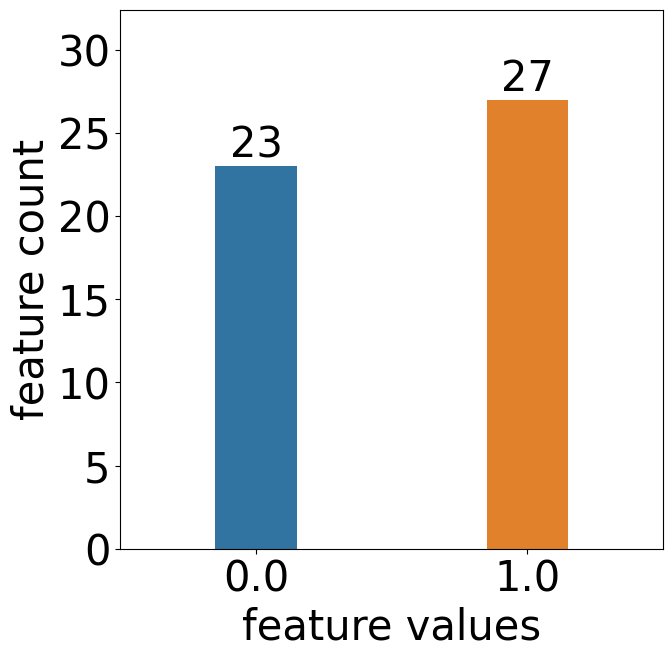

In [40]:
plots.count_plot(list2)

Number of nodes:  10
graph id:  graph2
Max pred probability for class 3 is 1.0


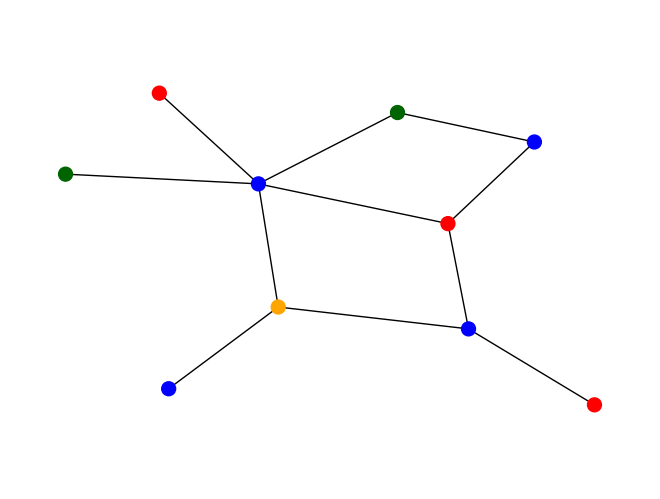

In [41]:
explanation_graph3 = plots.plot_graph(class3_graphid, max_pred3, 3, all_edges[class3_graphid],graph_dict[class3_graphid])

In [42]:
ind= utils.index_2d(softmax_dict[class3_graphid], max_pred3)[0]
list3= nodefeature_dict[class3_graphid]['author'].cpu().numpy()[ind]
Counter(list3)

Counter({0.0: 26, 1.0: 24})

In [43]:
print(list3)

[0. 0. 1. 0. 0. 1. 1. 1. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0.
 0. 1. 1. 0. 1. 0. 1. 0. 1. 0. 0. 0. 1. 1. 1. 0. 1. 1. 0. 0. 0. 0. 1. 1.
 1. 1.]


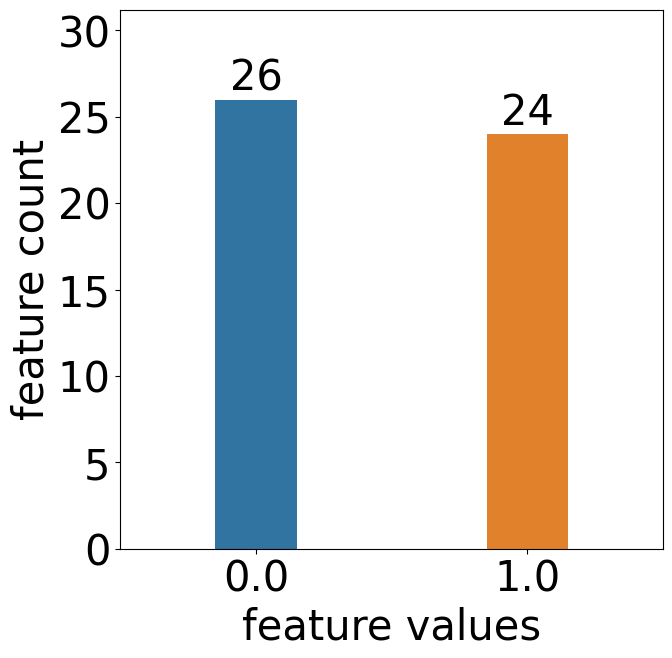

In [44]:
plots.count_plot(list3)

In [45]:
#Term Feature Statistics
term0_df = pd.DataFrame(nodefeature_dict[class0_graphid]['term'].cpu().numpy())
utils.print_stat_cont_features(term0_df)

mean 0.04531233
std dev 1.1695995


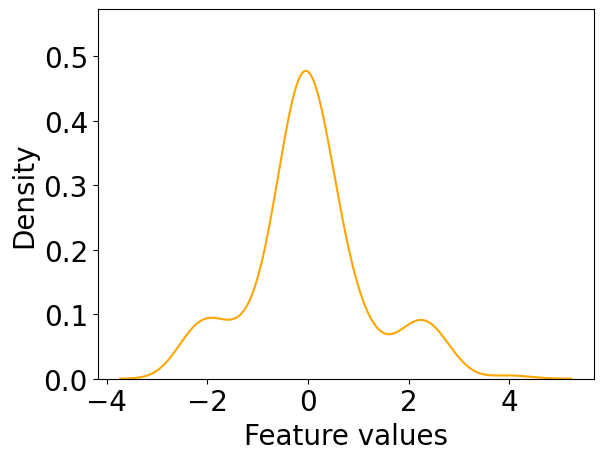

In [46]:
plots.plot_cont_feat(term0_df)

In [47]:
term1_df = pd.DataFrame(nodefeature_dict[class1_graphid]['term'].cpu().numpy())
utils.print_stat_cont_features(term1_df)

mean 0.03419107
std dev 0.6777873


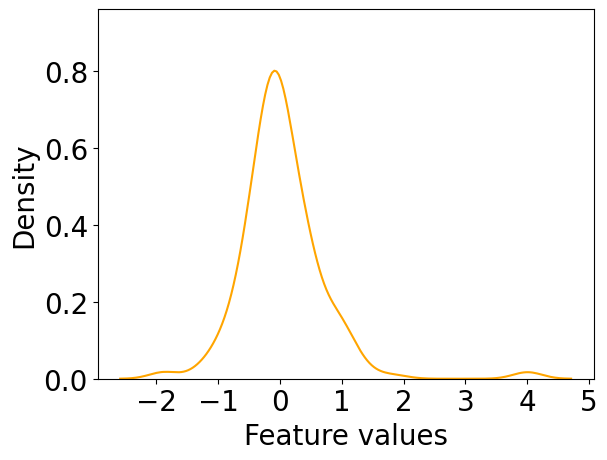

In [48]:
plots.plot_cont_feat(term1_df)

In [49]:
term2_df = pd.DataFrame(nodefeature_dict[class2_graphid]['term'].cpu().numpy())
utils.print_stat_cont_features(term2_df)

mean 0.06544878
std dev 1.222649


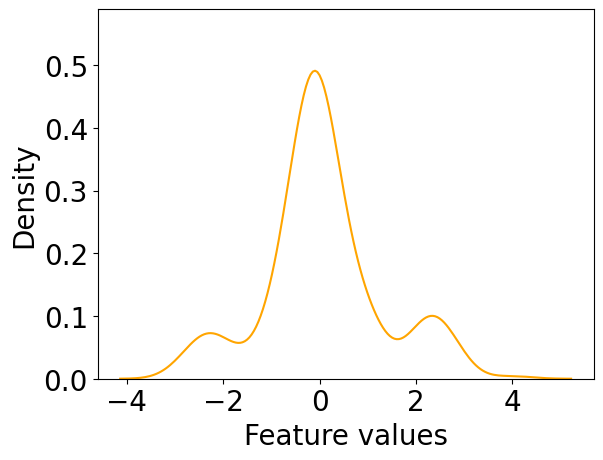

In [50]:
plots.plot_cont_feat(term2_df)

In [51]:
term3_df = pd.DataFrame(nodefeature_dict[class3_graphid]['term'].cpu().numpy())
utils.print_stat_cont_features(term3_df)

mean 0.04585683
std dev 0.74965465


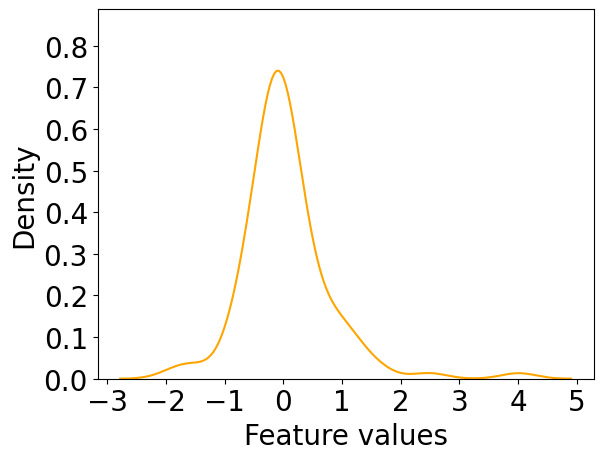

In [52]:
plots.plot_cont_feat(term3_df)

In [53]:
#Paper Features
paper0_df = pd.DataFrame(nodefeature_dict[class0_graphid]['paper'].cpu().numpy())

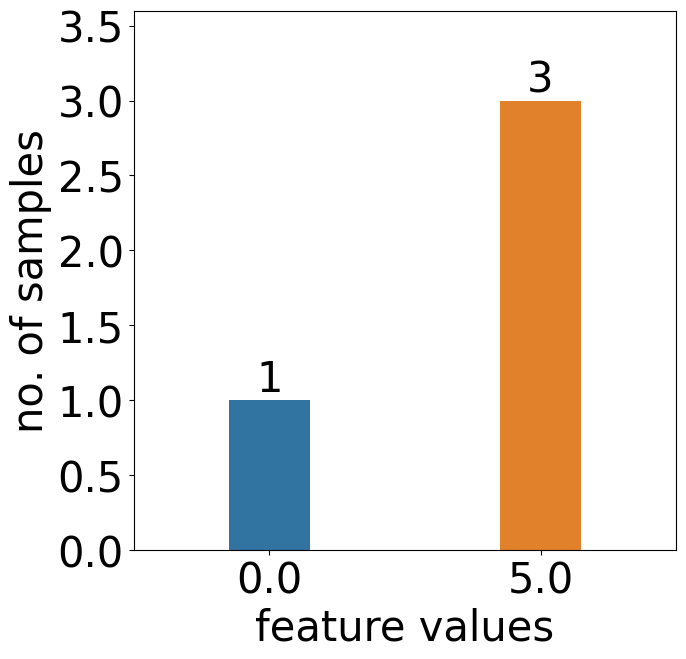

In [54]:
#imp_paper_feat0=feature_selection(paper0_df)   
imp_paper_feat0=utils.selected_features_freq(paper0_df,1)
plots.plot_imp_feature(imp_paper_feat0.values.tolist())

In [55]:
paper1_df = pd.DataFrame(nodefeature_dict[class1_graphid]['paper'].cpu().numpy())

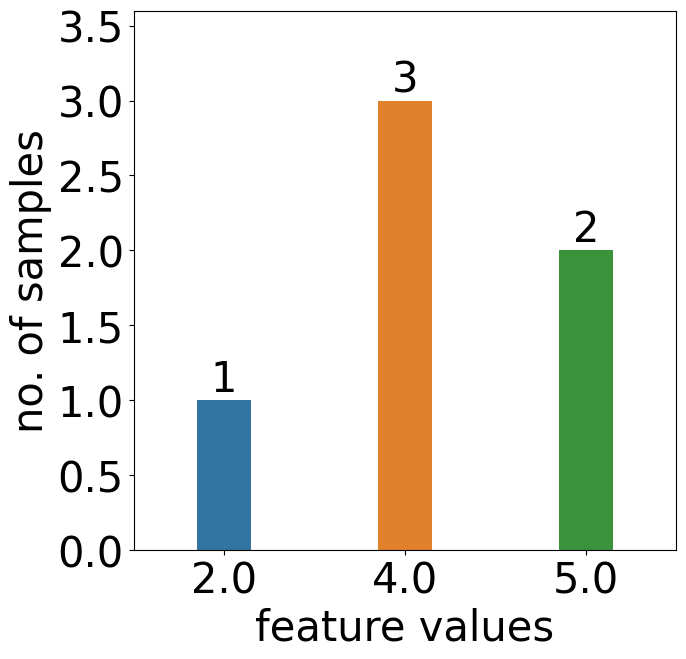

In [56]:
imp_paper_feat1=utils.selected_features_freq(paper1_df,1)
plots.plot_imp_feature(imp_paper_feat1.values.tolist())

In [57]:
paper2_df = pd.DataFrame(nodefeature_dict[class2_graphid]['paper'].cpu().numpy())

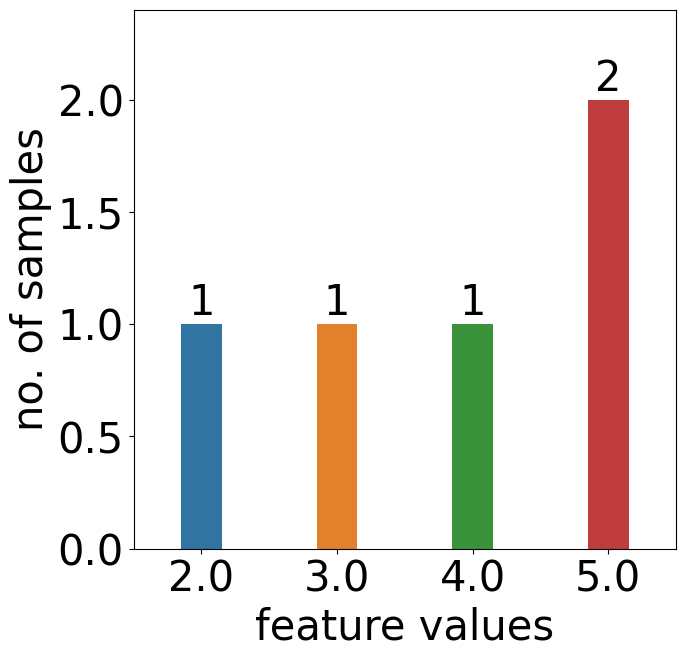

In [58]:
imp_paper_feat2=utils.selected_features_freq(paper2_df,1)
plots.plot_imp_feature(imp_paper_feat2.values.tolist())

In [59]:
paper3_df = pd.DataFrame(nodefeature_dict[class3_graphid]['paper'].cpu().numpy())

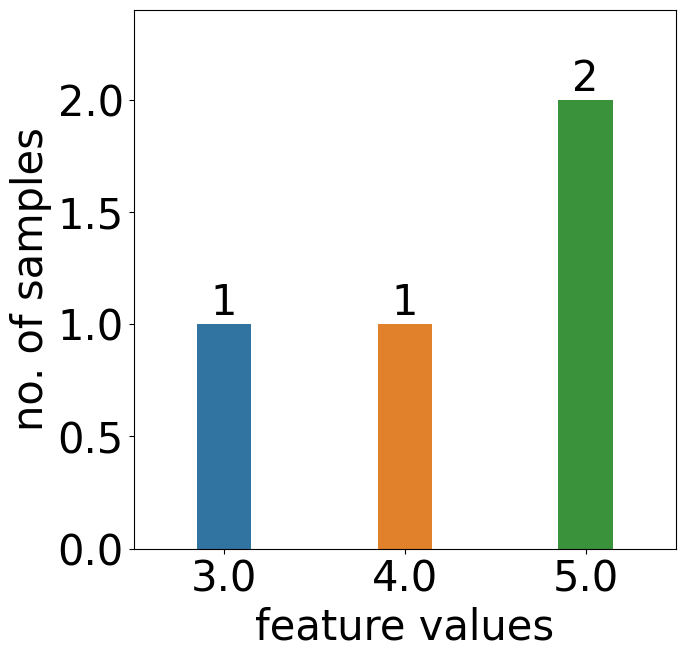

In [60]:
imp_paper_feat3=utils.selected_features_freq(paper3_df,1)
plots.plot_imp_feature(imp_paper_feat3.values.tolist())

## Ground-truth faithfulness

In [61]:
motifs_path = '../../motifs/dblp/'

In [62]:
from os import walk
w = walk(motifs_path)

for (dirpath, dirnames, filenames) in w:
    print(dirpath,filenames)

../../motifs/dblp/ []
../../motifs/dblp/class0 ['motif_real_dblp_17.gexf', 'motif_real_dblp_3.gexf', 'motif_real_dblp_35.gexf', 'motif_real_dblp_42.gexf', 'motif_real_dblp_5.gexf', 'motif_real_dblp_54.gexf', 'motif_real_dblp_76.gexf', 'motif_real_dblp_86.gexf', 'motif_real_dblp_90.gexf', 'motif_real_dblp_99.gexf']
../../motifs/dblp/class1 ['motif_real_dblp_10.gexf', 'motif_real_dblp_13.gexf', 'motif_real_dblp_23.gexf', 'motif_real_dblp_31.gexf', 'motif_real_dblp_41.gexf', 'motif_real_dblp_47.gexf', 'motif_real_dblp_64.gexf', 'motif_real_dblp_75.gexf', 'motif_real_dblp_80.gexf', 'motif_real_dblp_91.gexf']
../../motifs/dblp/class2 ['motif_real_dblp_15.gexf', 'motif_real_dblp_22.gexf', 'motif_real_dblp_39.gexf', 'motif_real_dblp_51.gexf', 'motif_real_dblp_56.gexf', 'motif_real_dblp_60.gexf', 'motif_real_dblp_72.gexf', 'motif_real_dblp_88.gexf', 'motif_real_dblp_97.gexf', 'motif_real_dblp_98.gexf']
../../motifs/dblp/class3 ['motif_real_dblp_11.gexf', 'motif_real_dblp_24.gexf', 'motif_real_

In [63]:
faithfulness_list = []

for i in range(0,RUNS):
    faithfulness = utils.get_faithfulness(class_graphid_list[i],all_edges_list[i],motifs_path)

    print('Run'+str(i),faithfulness)
    faithfulness_list.append(faithfulness)
print('Mean',np.mean(faithfulness_list))

Run0 0.9
Run1 0.8999999999999999
Run2 0.875
Run3 0.8999999999999999
Run4 0.875
Run5 0.8999999999999999
Run6 0.8
Run7 0.875
Run8 0.8999999999999999
Run9 0.8999999999999999
Mean 0.8825000000000001


In [64]:
print('Standard Deviation',np.std(faithfulness_list))

Standard Deviation 0.029685855217594755
